# Data Processing
The data used for this analysis was downloaded from the TCGA Pancancer Survival Prediction Challenge hosted on the Synapse website. This included separate text files on patients clinical covaiates, mRNA, miRNA, methylation, Reverse Phase Protein Array (RPPA), and Survival for  kidney renal clear cell carcinoma (OV).

In [1]:
from sklearn.ensemble import RandomForestClassifier
#load pandas
import pandas as pd
#load numpy
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix 
%matplotlib inline


For the OV the separate files were merged into a single dataframe using the TCGA barcode, a unique identifier of the biospecimen. This is important because we cannot assume that the biospecimens are in the same order in all the files. After this process only the samples with the survival information available remained, resulting in total number of samples of  379 (OV), whilst number of features was 43886.


The RandomForestClassifier used from scikit-learn library does not support strings or missing values as inputs. To solve this problem one hot encoding was applied to all the string features and missing values were replaced by zero’s. The process of one hot encoding increased the dimensionality of the data by less than 0.01% making it a viable solution.

In [194]:
OV_methylation="newOV.meth.by_mean.data.txt"
OV_miRNA="newOV.miRseq_mature_RPM.txt"
OV_mRNA="newOV.mRNA.data.txt"
OV_RPPA="newOV.rppa.txt"
OV_Survival="newOV.clin.merged.txt"

In [195]:

#one hot encoding
#alive dataframe
df_Sur = pd.read_csv(OV_Survival, sep='\t',index_col=0)
df_Sur=df_Sur.rename(columns={"patient.bcr_patient_barcode":"feature"})

df_Sur["feature"]=df_Sur["feature"].str.upper()
#combines dataframes

df_methylation=pd.read_csv(OV_methylation, sep='\t',index_col=0)
df_methylation=df_methylation.dropna(how='all', axis=1).fillna(0)

df_miRNA=pd.read_csv(OV_miRNA,sep='\t',index_col=0)
df_miRNA=df_miRNA.dropna(how='all', axis=1)
df_mRNA=pd.read_csv(OV_mRNA,sep='\t',index_col=0)
df_mRNA=df_mRNA.dropna(how='all', axis=1)
df_RPPA=pd.read_csv(OV_RPPA,sep='\t',index_col=0)
df_RPPA=df_RPPA.dropna(how='all', axis=1)

df_1=pd.merge(df_miRNA,df_methylation,on='feature')
df_2=pd.merge(df_mRNA,df_1,on='feature')
df_3=pd.merge(df_RPPA,df_2,on='feature')
df=pd.merge(df_3,df_Sur,on='feature')
df=df.fillna(0)
df = df.convert_objects(convert_numeric=True)
df=df.drop(['Composite Element REF_y'],axis=1)
df=df.drop(['Composite Element REF_x'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [196]:

#create test and train data
df['train'] = np.random.uniform(0,1,len(df))<0.80


In [197]:
#create dataframe with test and training
train=df[df['train']==True]
test=df[df['train']==False]
print("number of observations in training data:", len(train))
print("number of observations in test data:", len(test))

number of observations in training data: 359
number of observations in test data: 75


In [198]:
"""creates a list with features we want to train random tree on, first column has information on the TCGA barcode
   and last two columns have the is is_alive info and training.So we dont include those in the features"""
features=df.columns[1:-5]

#The output
df[features]=df[features].fillna(0)
y=train['is_alive']
top_features = open('/Users/Boubnovski/data_cancer/OV/OV_top_features.csv', 'r').read().split("\n")[:-1]


In [199]:
#create a random forest classifier

%time clf= RandomForestClassifier(n_jobs=2,n_estimators=10,max_features=None, random_state=0)

#training classifier
clf.fit(train[features].convert_objects(convert_numeric=True),y)
#Apply training classifier to test
train_predict=clf.predict(train[features].convert_objects(convert_numeric=True))
test_predict=clf.predict(test[features].convert_objects(convert_numeric=True))

CPU times: user 52 µs, sys: 19 µs, total: 71 µs
Wall time: 74.9 µs


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [200]:
%time clf_top= RandomForestClassifier(n_jobs=2,n_estimators=10,max_features=None, random_state=0)

#training classifier
clf_top.fit(train[top_features],y)
#Apply training classifier to test
train_predict_top=clf_top.predict(train[top_features])
test_predict_top=clf_top.predict(test[top_features])

CPU times: user 57 µs, sys: 1e+03 ns, total: 58 µs
Wall time: 65.1 µs


In [152]:
def perc_similarity(x, y):                                   
    """simple similarity function"""                         
    assert len(x) == len(y)
    count=np.sum(x == y)

    return(count/len(x))

In [153]:
#finds the percentage of values that have been predicted effectively
similarity_train = perc_similarity(train_predict, train['is_alive'])
similarity_test = perc_similarity(test_predict, test['is_alive'])   
print("Accuracy prediction on all features train data: "+str(similarity_train))
print("Accuracy prediction on all features test data: "+str(similarity_test))

similarity_train_top = perc_similarity(train_predict_top, train['is_alive'])
similarity_test_top= perc_similarity(test_predict_top, test['is_alive']) 
print("Accuracy prediction on top features train data: "+str(similarity_train_top))
print("Accuracy prediction on top features test data: "+str(similarity_test_top))


Accuracy prediction on all features train data: 1.0
Accuracy prediction on all features test data: 0.7037037037037037
Accuracy prediction on top features train data: 0.9886685552407932
Accuracy prediction on top features test data: 0.691358024691358


In [125]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = df[features].columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [126]:
feature_importances
pd.to_csv("ALL_features_ordered_by importance.csv")

,importance
HIRIP3_x,0.047054
FAM3A,0.046177
ARHGAP26_y,0.041036
KIF25_y,0.029563
OGFR_x,0.027750
FAM107B_x,0.027476
THOP1_x,0.023738
WDR4_y,0.022714
FLRT2_x,0.020550
UBR2_y,0.018935


# Leave one out random forest
A function was then defined in python to implement the leave one out random forest using the RandomForestClassifier on the training set, and extract the most important features using the method feature_importances_ defined in the scikit-learn library.  This process was iterated through the whole training set, calculating the mean feature importance and ordering the results in descending order. 


In [179]:
def leave_one_out(df,is_alive,features):
    #outputs "outcome" a list containing the survival or death prediction 
    #outputs "dic" a dictionary containing the feature and its importance
    indexes=list(df.index)
    outcome=[]
    dic={}
    for i in indexes:
        df=df.assign(train=True)
        df.train[i]=False
        train_one=df[df['train']==True]
        test_one=df[df['train']==False]
        y_one=train_one['is_alive']    
        clf= RandomForestClassifier(n_estimators=100,max_features=None, n_jobs=2,random_state=0)
        clf.fit(train_one[features],y_one)
        #a.append((clf.predict(test[features])).tolist())
        outcome=outcome+((clf.predict(test_one[features])).tolist())
        dic1=dict(zip(test_one[features].columns, clf.feature_importances_))
        #adds the importance of all features
        dic = {key: dic.get(key, 0) + dic1.get(key, 0)
          for key in set(dic) | set(dic1)}
   
    return(outcome,dic)

To reduce the dimensionality and extract only relevant features for predicting the survival, a cross validation approach was chosen. So only the training set will be used to extract the important features. 


In [130]:

ans,most_import=leave_one_out(train,"is_alive",features)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

In [131]:
#leave one out random treat accuracy accuracy
perc_similarity(ans, train["is_alive"])

0.7393767705382436

In [132]:

sorted_d = sorted(most_import.items(), key=operator.itemgetter(1),reverse=True)
sorted_d
im_features,im_values=zip(*sorted_d)
im_features=list(im_features)
im_features

['THOP1_x',
 'DPM3_x',
 'IGF2R_x',
 'HSPE1_x',
 'DDX28_x',
 'HMG20B_x',
 'RNASEL',
 'hsa-miR-143-3p|MIMAT0000435',
 'TCN1_y',
 'DYNLT1_y',
 'NPEPL1',
 'FAM3A',
 'HIRIP3_x',
 'PPP1R2P1',
 'C12orf24_x',
 'TUSC4_x',
 'TSEN34_x',
 'HSD17B3_y',
 'CACNB1_y',
 'TMEM129_y',
 'C17orf64',
 'KIF25_y',
 'hsa-miR-221-5p|MIMAT0004568',
 'ARHGAP26_y',
 'MAP3K7IP2_x',
 'SNX9',
 'C9orf100_x',
 'FAHD2B',
 'CCDC80_x',
 'PM20D1',
 'hsa-miR-331-5p|MIMAT0004700',
 'SIRT5_x',
 'NUDT8_x',
 'ADPGK',
 'SYT8_x',
 'DOM3Z_x',
 'C7_y',
 'ENPP6_y',
 'FLJ10038',
 'TACC3_y',
 'SCO2_x',
 'MAGEE1',
 'MAP6D1_x',
 'FLJ14213',
 'TM9SF3_x',
 'KCNK5_x',
 'MTOR|mTOR_pS2448',
 'USP8_x',
 'TMC2_x',
 'FSTL1_x',
 'PAICS_y',
 'UCHL5IP',
 'MCF2L2_x',
 'LCOR_x',
 'OPLAH',
 'RPP25_x',
 'REV3L_y',
 'hsa-miR-199a-3p|MIMAT0000232',
 'GLOD5',
 'TMEM100_y',
 'CCDC88A_y',
 'LOC116349',
 'EIF2S2_y',
 'C11orf57_x',
 'CAMK1D_x',
 'VEZT',
 'NQO2_x',
 'PLS3',
 'CACNA2D3',
 'TK1_x',
 'TPPP',
 'USP8_y',
 'ALKBH7_x',
 'C10orf76',
 'MRPS26_x',
 'SF

# Find the best combination of features

To find the optimal number of important features for each cancer, the accuracy of the leave one out random forest was calculated as the number of important features was increased by one. At the point of maxima accuracy, the most important features were saved into array labelled “Top Features”. 

In [166]:
def best_features(df,all_features):
    score={}
    df['train'] = np.random.uniform(0,1,len(df))<0.80
    train=df[df['train']==True]
    test=df[df['train']==False]
    y=train['is_alive'] 
    for i in range(5000):
        clf= RandomForestClassifier(n_estimators=100, n_jobs=2,random_state=0)
        clf.fit(train[all_features[:i+1]],y)
        test_predict=clf.predict(test[all_features[:i+1]])
        
        similarity_test = perc_similarity(test_predict, test['is_alive']) 
        score[i+1]=similarity_test
    return(score)
        
        

In [167]:
s=best_features(train,im_features)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [168]:
max(s.values())

for name, age in s.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if age == max(s.values()):
        top_number_to_include=name
        print(name)

7
183
237
516
1542
2331
2418
2733


In [170]:
pd.DataFrame(im_features[:183]).to_csv('OV_top_features.csv', index=False, header=False)

In [173]:
ans,most_import=leave_one_out(test,"is_alive",im_features)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

In [174]:
similarity = perc_similarity(test["is_alive"], ans )
similarity

0.6172839506172839

In [175]:
pd.DataFrame(im_features[:112]).to_csv('OV_top_features_100trees.csv', index=False, header=False)

Part2

In [16]:
top_features = open('OV_top_features_100trees.csv', 'r').read().split("\n")[:-1]
df_top_features=df[["feature"]+top_features[:-1]]

x = StandardScaler().fit_transform(df_top_features.drop('feature', axis=1) )
len(x),len(df_top_features)

(434, 434)

In [30]:
for i in range(len(top_features)):
    top_features[i]=top_features[i].split('_')[0]
top_features

df_top_features = pd.DataFrame.from_dict(Counter(top_features), orient='index')

In [180]:
clf = RandomForestClassifier(bootstrap= True,max_depth= 100, max_features='sqrt', min_samples_leaf= 4,min_samples_split= 2,n_estimators= 1600 )
clf.fit(train[features],y)
b=clf.predict(test[features])

cf = RandomForestClassifier(bootstrap= True,max_depth= 100, max_features='sqrt', min_samples_leaf= 4,min_samples_split= 2,n_estimators= 1600 )
cf.fit(train[im_features[:112]],y)
a=cf.predict(test[im_features[:112]])

In [181]:
similarity = perc_similarity(a, test['is_alive'])    
similarity

0.6790123456790124

ROC AUC improved features: 0.77
ROC AUC all features: 0.78


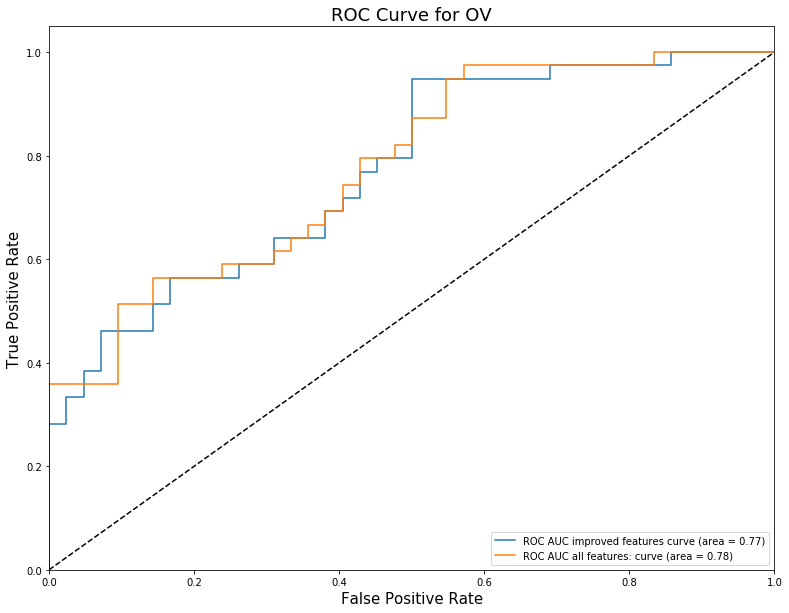

In [182]:

fpr, tpr, _ = roc_curve(test['is_alive'], cf.predict_proba(test[im_features[:112]])[:, 1])



# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC improved features: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure(0).clf()
plt.figure(figsize=(13,10))
plt.plot(fpr, tpr, label='ROC AUC improved features curve (area = %0.2f)' % roc_auc)

fpr, tpr, _ = roc_curve(test['is_alive'], clf.predict_proba(test[features])[:, 1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC all features: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class


plt.plot(fpr, tpr, label='ROC AUC all features: curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('ROC Curve for OV',fontsize=18)
plt.legend(loc="lower right")
plt.savefig("OV_ROC.png", bbox_inches='tight')
plt.show()

In [183]:
X = df[im_features[:112]]
y = df['is_alive'] 
X_all=df[features]
y_all= df['is_alive'] 

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 
X_all_train, X__all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size = 0.20) 

In [185]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train)

svclassifier_all= SVC(kernel='linear')  
svclassifier_all.fit(X_all_train, y_all_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [186]:
y_pred = svclassifier.predict(X_test)

y_all_pred =svclassifier_all.predict(X__all_test)

In [187]:
print("OV important features")
#print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

print("OV all features")
#print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_all_test,y_all_pred)) 

OV important features
              precision    recall  f1-score   support

           0       0.73      0.82      0.77        49
           1       0.72      0.61      0.66        38

   micro avg       0.72      0.72      0.72        87
   macro avg       0.72      0.71      0.71        87
weighted avg       0.72      0.72      0.72        87

OV all features
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        43
           1       0.70      0.68      0.69        44

   micro avg       0.69      0.69      0.69        87
   macro avg       0.69      0.69      0.69        87
weighted avg       0.69      0.69      0.69        87



# Random forest survival

The Random forest survival uses the top features calculated in the leave one out random forest method.

In [4]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [5]:
d_inf=pd.read_csv("newOV.clin.merged.txt","\t",index_col=0)
d_inf=d_inf.rename(columns={"patient.bcr_patient_barcode":"feature"})
d_inf["feature"]=d_inf["feature"].str.upper()

In [6]:
d_inf["limit_of days"]=d_inf["patient.days_to_death"]
d_inf['limit_of days']=d_inf['limit_of days'].fillna(d_inf['patient.days_to_last_followup'])
d_inf["is_true"]=d_inf["patient.days_to_death"].notnull().values
d_inf=d_inf[:580]
d_inf = d_inf[np.isfinite(d_inf['limit_of days'])]

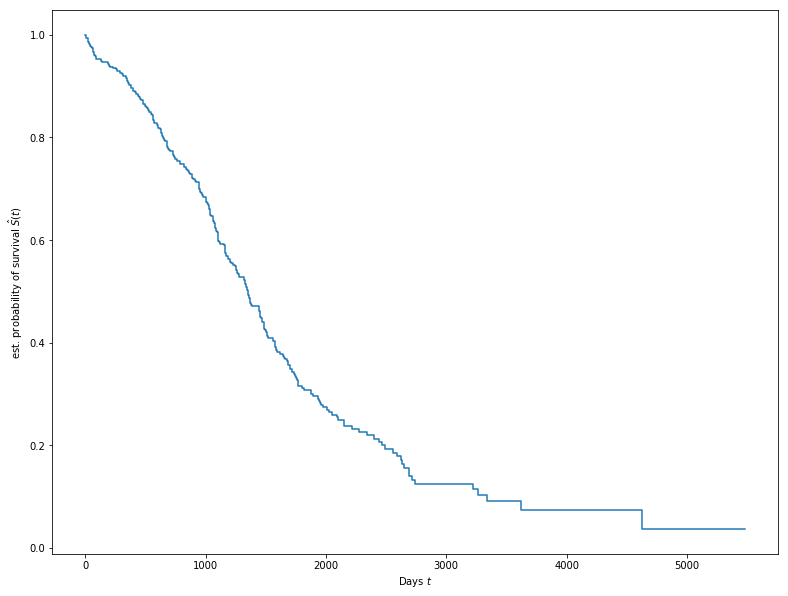

In [7]:
time, survival_prob = kaplan_meier_estimator(d_inf["is_true"], d_inf["limit_of days"])
plt.figure(figsize=(13,10))
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("Days $t$")


In [171]:
df_sur_mod=pd.merge(df[df.columns[:-5]],d_inf,on='feature')
X_train, X_test, y_train, y_test = train_test_split(df_sur_mod[top_features], df_sur_mod[["is_true","limit_of days"]], test_size=0.20, random_state=26)

In [179]:
estimator = CoxPHSurvivalAnalysis()
train_y=y_train.reindex(columns=["is_true","limit_of days"])
test_y=y_test.reindex(columns=["is_true","limit_of days"])
#estimator.fit(df_sur_mod[features], array)

In [180]:
#create test and train data

dt = [('is_true', bool), ('limit_of days', int)]
#array = np.array(y_data.values, dtype=dtype)
train_arr = np.array([tuple(v) for v in train_y.values.tolist()], dtype=dt)
test_arr=np.array([tuple(v) for v in test_y.values.tolist()], dtype=dt)

In [187]:
estimator.fit(X_train[top_features][:-1], train_arr[:-1])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.3052279732244035e-35
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.941122002667789e-35
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.165481676667776e-35
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framew

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.4781763942521635e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.2338774101404174e-33
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.120012747996933e-34
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.frame

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2390881971259392e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.4781763942525155e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.4807121274231994e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.fram

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2390881971260998e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.859035759311243e-34
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.369107080370864e-34
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Library/Frameworks/Python.framew

0.8478580351238151

 Harrell's concordance index or c-index.

In [188]:
estimator.score(X_train[top_features][:-1], train_arr[:-1])

0.8478580351238151

The result is a vector of coefficients, one for each variable, where each value corresponds to the log hazard ratio.

In [175]:
pd.Series(estimator.coef_, index=X_train.columns)

THOP1_x                       -3.682971e-01
DPM3_x                         7.282205e-01
IGF2R_x                       -2.756162e-01
HSPE1_x                       -2.714900e-01
DDX28_x                       -5.531868e-01
HMG20B_x                       1.152510e+00
RNASEL                        -7.202670e-01
hsa-miR-143-3p|MIMAT0000435    5.418043e-05
TCN1_y                        -3.455568e+00
DYNLT1_y                       5.789809e+00
NPEPL1                        -1.802255e-01
FAM3A                         -8.917124e-01
HIRIP3_x                      -8.852297e-01
PPP1R2P1                      -1.779583e+00
C12orf24_x                    -9.318263e-01
TUSC4_x                       -5.674144e-01
TSEN34_x                       8.973091e-01
HSD17B3_y                      2.951008e-03
CACNB1_y                      -5.936678e+01
TMEM129_y                     -4.847729e+14
C17orf64                      -1.013448e+00
KIF25_y                       -1.339187e+00
hsa-miR-221-5p|MIMAT0004568   -9

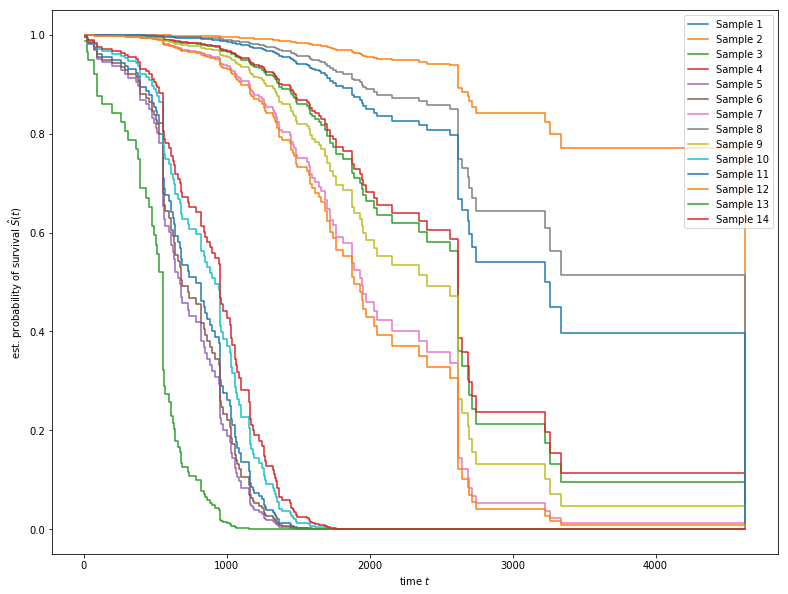

In [190]:
pred_surv = estimator.predict_survival_function(X_test[1:15])
plt.figure(figsize=(13,10))
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
